In [1]:
import requests
import plotly.graph_objects as go
import pandas as pd
from datetime import datetime,timedelta
from collections import defaultdict
import dateutil.parser
import finplot as fplt
import pytz
import numpy as np 
import matplotlib.pyplot as plt
import os 

utc2timestamp = lambda s: int(dateutil.parser.parse(s).replace(tzinfo=pytz.utc).timestamp() * 1000)

In [16]:
#https://dev.binance.vision/t/aggtrades-retrieving-data-over-a-date-range/14050/10
from zipfile import ZipFile

df = pd.read_csv(ZipFile("../data-storage/spot/daily/aggTrades/BTCUSDT/2023-08-01_2023-08-20/BTCUSDT-aggTrades-2023-08-19.zip").open("BTCUSDT-aggTrades-2023-08-19.csv"), names=["aggregated_id","price","quantity","first_trade_id","last_trade_id","last_timestamp","is_buyer_maker","is_best_match"])    

In [ ]:
# Developing a function to round to a multiple
def round_to_multiple(number, multiple):
    return multiple * round(number / multiple)

In [ ]:
df

,aggregated_id,price,quantity,first_trade_id,last_trade_id,last_timestamp,is_buyer_maker,is_best_match
0,2690689041,26054.00,0.00186,3195189945,3195189945,1692403200001,False,True
1,2690689042,26054.00,0.00157,3195189946,3195189946,1692403200007,False,True
2,2690689043,26053.99,0.00310,3195189947,3195189947,1692403200007,True,True
3,2690689044,26053.99,0.00096,3195189948,3195189948,1692403200007,True,True
4,2690689045,26053.99,0.00531,3195189949,3195189949,1692403200007,True,True
...,...,...,...,...,...,...,...,...
464956,2691153997,26100.00,0.00094,3195805704,3195805704,1692489599995,True,True
464957,2691153998,26100.00,0.00223,3195805705,3195805705,1692489599997,True,True
464958,2691153999,26100.00,0.00049,3195805706,3195805706,1692489599997,True,True
464959,2691154000,26100.01,0.00048,3195805707,3195805707,1692489599998,False,True


https://github.com/binance/binance-spot-api-docs/blob/master/faqs/market_data_only.md

https://onlinelibrary.wiley.com/doi/pdf/10.1002/9781118659724.app1

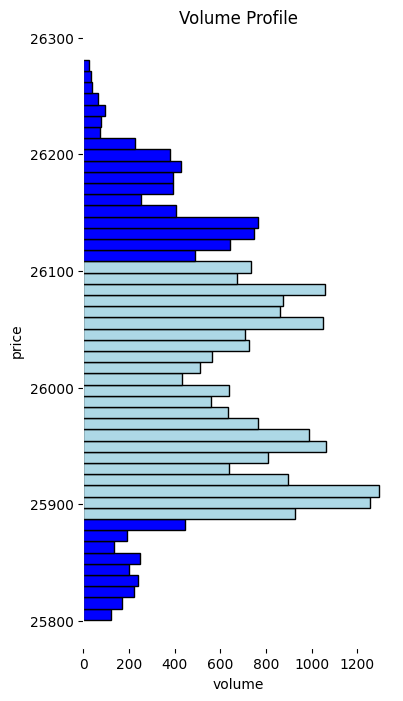

PoC Price: 25906.6702
Value Area (68%): 25887.4738 to 26098.6342


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def create_volume_profile_ticks(data, num_bins):
    # Calculate the price range for binning
    data['ohlc4'] = data.price # assume this is volume center per each 1m candle
    min_price = data['ohlc4'].min()
    max_price = data['ohlc4'].max()
    price_range = max_price - min_price

    # Calculate the bin size
    bin_size = price_range / num_bins

    # Create the bins
    bins = [min_price + i * bin_size for i in range(num_bins + 1)]

    # Bin the data and calculate total volume for each bin
    volume_profile = []
    for i in range(num_bins):
        bin_data = data[(data['ohlc4'] >= bins[i]) & (data['ohlc4'] < bins[i+1])]
        total_volume = bin_data['quantity'].sum()
        volume_profile.append(total_volume)

    return bins[:-1], volume_profile

def plot_volume_profile(bins, volume_profile, value_area_low, value_area_high):
    colors = ['lightblue' if bins[i] >= value_area_low and bins[i] <= value_area_high else 'b' for i in range(len(bins))]
    fig,ax = plt.subplots(figsize=(4,8))
    plt.barh(bins, volume_profile, height=(bins[1]-bins[0]), align='edge', ec='black', color=colors)
    plt.rcParams['axes.edgecolor'] = 'white'
    plt.xlabel('volume')
    plt.ylabel('price')
    plt.title('Volume Profile')   
    plt.show()

def calculate_point_of_control(bins, volume_profile):
    poc_index = np.argmax(volume_profile)
    point_of_control = bins[poc_index]
    
    return point_of_control

def calculate_value_area_with_highest_dual_bins(bins, volume_profile, percentage):
    # Find the index of the bin with the greatest volume
    highest_volume_index = volume_profile.index(max(volume_profile))

    # Initialize variables to track the value area
    value_area_low = bins[highest_volume_index]
    value_area_high = bins[highest_volume_index]
    value_area_volume = volume_profile[highest_volume_index]
    high_index = 0
    low_index = 0

    # Calculate the total volume
    total_volume = sum(volume_profile)

    # Calculate the target volume for the Value Area (68% of the total volume)
    target_volume = total_volume * percentage / 100
    

    # Loop until the value area reaches 68% of the total volume or no more bins to check
    while value_area_volume <= target_volume:
        # Calculate the total volume of the dual bins above and below
        
        dual_bins_volume_above = volume_profile[highest_volume_index + 1 + high_index] + volume_profile[highest_volume_index + 2 + high_index]
        dual_bins_volume_below = volume_profile[highest_volume_index - 1 - low_index] + volume_profile[highest_volume_index - 2 - low_index]
        
        # Compare the dual bins volume and update the value area if needed
        if dual_bins_volume_above >= dual_bins_volume_below:
            value_area_volume += dual_bins_volume_above
            value_area_high = bins[highest_volume_index + 2 + high_index]
            high_index += 2
        else:
            value_area_volume += dual_bins_volume_below
            value_area_low = bins[highest_volume_index - 2 - low_index]
            low_index += 2
        
    return value_area_low, value_area_high

# Number of bins for the volume profile
num_bins = 50
# Create volume profile
bins, volume_profile = create_volume_profile_ticks(df.copy(), num_bins)

data = {
    'bins': bins,
    'volume_profile': volume_profile
}

# Create a DataFrame from the dictionary
df_vol = pd.DataFrame(data)

df_sorted = df_vol.sort_values(by='volume_profile', ascending=False)

df_sorted['cumulative_volume'] = df_sorted['volume_profile'].cumsum()

total_sum = df_sorted['volume_profile'].sum()

df_sorted['percentage'] = (df_sorted['volume_profile'] / total_sum) * 100

# Calculate the Point of Control
point_of_control = df_sorted.loc[df_sorted['volume_profile'].idxmax(), 'bins']

# Calculate the Value Area (using the function with dual bins)
percentage = 68
value_area_low, value_area_high = calculate_value_area_with_highest_dual_bins(bins, volume_profile, percentage)

# Plot volume profile with Value Area
plot_volume_profile(bins, volume_profile, value_area_low, value_area_high)

print(f"PoC Price: {point_of_control}")
print(f"Value Area (68%): {value_area_low} to {value_area_high}")
